In [1]:
import argparse
import collections
import cProfile
import datetime
import hashlib
import itertools
import math
import os
import pstats
import re
import shutil
import signal
import statistics
import string
from datetime import datetime
from tabulate import tabulate
from io import StringIO

import matplotlib
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torchaudio
from matplotlib import pyplot as plt
from torch import nn, topk
from torch.optim import SGD, Adadelta, Adam
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchaudio.datasets import LIBRISPEECH, SPEECHCOMMANDS
from torchaudio.transforms import MFCC, Resample
from tqdm.notebook import tqdm as tqdm

print("start time: {}".format(str(datetime.now())), flush=True)

if __name__ == '__main__':
    mp.set_start_method('forkserver')

try:
    %matplotlib inline
    in_notebook = True
except NameError:
    matplotlib.use("Agg")
    in_notebook = False

# Empty CUDA cache
torch.cuda.empty_cache()

# Profiling performance
pr = cProfile.Profile()
pr.enable()

start time: 2020-03-30 12:54:31.717699


In [3]:
# Create argument parser
parser = argparse.ArgumentParser()

parser.add_argument('--workers', default=0, type=int,
                    metavar='N', help='number of data loading workers')
parser.add_argument('--resume', default='', type=str,
                    metavar='PATH', help='path to latest checkpoint')

parser.add_argument('--epochs', default=200, type=int,
                    metavar='N', help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int,
                    metavar='N', help='manual epoch number')
parser.add_argument('--print-freq', default=10, type=int,
                    metavar='N', help='print frequency in epochs')

parser.add_argument('--batch-size', default=64, type=int,
                    metavar='N', help='mini-batch size')
parser.add_argument('--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
# parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', default=1e-5,
                    type=float, metavar='W', help='weight decay')
parser.add_argument("--eps", metavar='EPS', type=float, default=1e-8)
parser.add_argument("--rho", metavar='RHO', type=float, default=.95)

parser.add_argument('--world-size', default=1, type=int,
                    help='number of distributed processes')
parser.add_argument('--dist-url', default='tcp://224.66.41.62:23456',
                    type=str, help='url used to set up distributed training')
parser.add_argument('--dist-backend', default='nccl',
                    type=str, help='distributed backend')
parser.add_argument('--dataset', default='librispeech', type=str)

args, _ = parser.parse_known_args()
# args = parser.parse_args()

# Checkpoint

In [27]:
MAIN_PID = os.getpid()
CHECKPOINT_filename = args.resume if args.resume else 'checkpoint.pth.tar'
CHECKPOINT_tempfile = CHECKPOINT_filename + '.temp'
HALT_filename = CHECKPOINT_filename + '.HALT'
SIGNAL_RECEIVED = False

''' HALT file is used as a sign of job completion.
Make sure no HALT file left from previous runs.
'''
if os.path.isfile(HALT_filename):
    os.remove(HALT_filename)

''' Remove CHECKPOINT_tempfile, in case the signal arrives in the
middle of copying from CHECKPOINT_tempfile to CHECKPOINT_filename
'''
if os.path.isfile(CHECKPOINT_tempfile):
    os.remove(CHECKPOINT_tempfile)


def SIGTERM_handler(a, b):
    print('received sigterm')
    pass


def signal_handler(a, b):
    global SIGNAL_RECEIVED
    print('Signal received', a, datetime.now().strftime(
        "%y%m%d.%H%M%S"), flush=True)
    SIGNAL_RECEIVED = True

    ''' If HALT file exists, which means the job is done, exit peacefully.
    '''
    if os.path.isfile(HALT_filename):
        print('Job is done, exiting')
        exit(0)

    return


def trigger_job_requeue():
    ''' Submit a new job to resume from checkpoint.
    '''
    if os.path.isfile(CHECKPOINT_filename) and \
       os.environ['SLURM_PROCID'] == '0' and \
       os.getpid() == MAIN_PID:
        print('pid: ', os.getpid(), ' ppid: ', os.getppid(), flush=True)
        print('time is up, back to slurm queue', flush=True)
        command = 'scontrol requeue ' + os.environ['SLURM_JOB_ID']
        print(command)
        if os.system(command):
            raise RuntimeError('requeue failed')
        print('New job submitted to the queue', flush=True)
    exit(0)


''' Install signal handler
'''
signal.signal(signal.SIGUSR1, signal_handler)
signal.signal(signal.SIGTERM, SIGTERM_handler)
print('Signal handler installed', flush=True)


def save_checkpoint(state, is_best, filename=CHECKPOINT_filename):
    ''' Save the model to a temporary file first,
    then copy it to filename, in case the signal interrupts
    the torch.save() process.
    '''
    if not args.distributed or os.environ['SLURM_PROCID'] == '0':
        torch.save(state, CHECKPOINT_tempfile)
        if os.path.isfile(CHECKPOINT_tempfile):
            os.rename(CHECKPOINT_tempfile, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best.pth.tar')
        print("Checkpoint done")

Signal handler installed


# Distributed

In [5]:
# Use #nodes as world_size
if 'SLURM_NNODES' in os.environ:
    args.world_size = int(os.environ['SLURM_NNODES'])
args.distributed = args.world_size > 1

if args.distributed:
    os.environ['RANK'] = os.environ['SLURM_PROCID']
    os.environ['WORLD_SIZE'] = str(args.world_size)
    print('in distributed', os.environ['RANK'],
          os.environ['MASTER_ADDR'], os.environ['MASTER_PORT'], flush=True)
    dist.init_process_group(backend=args.dist_backend,
                            init_method=args.dist_url, world_size=args.world_size)

    print('init process', flush=True)

# Parameters

In [6]:
audio_backend = "soundfile"
torchaudio.set_audio_backend(audio_backend)

root = "/datasets01/"
folder_in_archive = "librispeech/062419/"

device = "cuda" if torch.cuda.is_available() else "cpu"
num_devices = torch.cuda.device_count()
# num_devices = 1
print(num_devices, "GPUs", flush=True)

# max number of sentences per batch
batch_size = args.batch_size
# batch_size = 2048
# batch_size = 512
# batch_size = 256
# batch_size = 64
batch_size = 1

training_percentage = 90.
validation_percentage = 5.

data_loader_training_params = {
    "num_workers": args.workers,
    "pin_memory": True,
    "shuffle": True,
    "drop_last": True,
}
data_loader_validation_params = data_loader_training_params.copy()
data_loader_validation_params["shuffle"] = False

non_blocking = True


# text preprocessing

char_null = "-"
char_space = " "
char_pad = "*"
char_apostrophe = "'"

labels = [char_null + char_pad + char_apostrophe + string.ascii_lowercase]

# excluded_dir = ["_background_noise_"]
# folder_speechcommands = './SpeechCommands/speech_commands_v0.02'
# labels = [char_null, char_pad] + [d for d in next(os.walk(folder_speechcommands))[1] if d not in excluded_dir]


# audio

sample_rate_original = 16000
sample_rate_new = 8000
# resample = Resample(sample_rate_original, sample_rate_new).to(device)
resample = None

n_mfcc = 13
melkwargs = {
    'n_fft': 512,
    'n_mels': 20,
    'hop_length': 80,  # (160, 80)
}
mfcc = MFCC(sample_rate=sample_rate_original,
            n_mfcc=n_mfcc, melkwargs=melkwargs).to(device)
# mfcc = None


# Optimizer

optimizer_params_adadelta = {
    "lr": 1.0,
    "eps": 1e-8,
    "rho": 0.95,
    "weight_decay": 1e-5,
}

optimizer_params_adam = {
    "lr": .05,
    "eps": 1e-8,
    "weight_decay": .01,
}

optimizer_params_sgd = {
    "lr": .001,
    "weight_decay": .0001,
}

optimizer_params_adadelta = {
    "lr": args.learning_rate,
    "eps": args.eps,
    "rho": args.rho,
    "weight_decay": args.weight_decay,
}

Optimizer = Adadelta
optimizer_params = optimizer_params_adadelta

gamma = 0.95


# Model

num_features = n_mfcc if n_mfcc else 1

lstm_params = {
    "num_layers": 3,
    "batch_first": False,
    "bidirectional": False,
    "dropout": 0.,
}

clip_norm = 0.  # 10.

zero_infinity = False

start_epoch = args.start_epoch
max_epoch = args.epochs
mod_epoch = args.print_freq

dtstamp = datetime.now().strftime("%y%m%d.%H%M%S")
print(dtstamp, flush=True)

2 GPUs
200330.125556


# Text encoding

In [7]:
class Coder:
    def __init__(self, labels):
        labels = list(collections.OrderedDict.fromkeys(list("".join(labels))))
        self.length = len(labels)
        enumerated = list(enumerate(labels))
        flipped = [(sub[1], sub[0]) for sub in enumerated]

        d1 = collections.OrderedDict(enumerated)
        d2 = collections.OrderedDict(flipped)
        self.mapping = {**d1, **d2}
        self.mapping[char_space] = self.mapping[char_pad]

    def _map(self, iterable):
        # iterable to iterable
        return [self.mapping[i] for i in iterable]

    def encode(self, iterable):
        if isinstance(iterable[0], list):
            return [self.encode(i) for i in iterable]
        else:
            return self._map(iterable)

    def decode(self, tensor):
        if isinstance(tensor[0], list):
            return [self.decode(t) for t in tensor]
        else:
            # not idempotent, since clean string
            return "".join(self._map(tensor)).replace(char_null, "").replace(char_pad, char_space).strip()


coder = Coder(labels)
encode = coder.encode
decode = coder.decode
vocab_size = coder.length
print(vocab_size, flush=True)

29


# Dataset

In [8]:
class IterableMemoryCache:

    def __init__(self, iterable):
        self.iterable = iterable
        self._iter = iter(iterable)
        self._done = False
        self._values = []

    def __iter__(self):
        if self._done:
            return iter(self._values)
        return itertools.chain(self._values, self._gen_iter())

    def _gen_iter(self):
        for new_value in self._iter:
            self._values.append(new_value)
            yield new_value
        self._done = True

    def __len__(self):
        return len(self._iterable)


class MapMemoryCache(torch.utils.data.Dataset):
    """
    Wrap a dataset so that, whenever a new item is returned, it is saved to memory.
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self._cache = [None] * len(dataset)

    def __getitem__(self, n):
        if self._cache[n]:
            return self._cache[n]

        item = self.dataset[n]
        self._cache[n] = item

        return item

    def __len__(self):
        return len(self.dataset)


class Processed(torch.utils.data.Dataset):

    def __init__(self, process_datapoint, dataset):
        self.process_datapoint = process_datapoint
        self.dataset = dataset

    def __getitem__(self, n):
        try:
            item = self.dataset[n]
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return None

    def __next__(self):
        try:
            item = next(self.dataset)
            return self.process_datapoint(item)
        except (FileNotFoundError, RuntimeError):
            return self.__next__()

    def __len__(self):
        return len(self.dataset)

In [9]:
# @torch.jit.script
def process_datapoint(item):
    transformed = item[0].to(device, non_blocking=non_blocking)
    target = item[2].lower().replace(char_space, char_pad)

    # apply mfcc, tranpose for pad_sequence
    if resample is not None:
        transformed = resample(transformed)

    if mfcc is not None:
        transformed = mfcc(transformed)
    else:
        transformed = transformed.unsqueeze(1)

    transformed = transformed[0, ...].transpose(0, -1)

    target = " " + target + " "
    target = encode(target)
    target = torch.tensor(target, dtype=torch.long, device=transformed.device)

    transformed = transformed.to("cpu")
    target = target.to("cpu")
    return transformed, target

In [10]:
def datasets_librispeech():

    def create(tag):
        data = LIBRISPEECH(
            root, tag, folder_in_archive=folder_in_archive, download=False)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("train-clean-100"), create("dev-clean"), None

In [11]:
def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_nohash_' in a filename is
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and
    'bobby_nohash_1.wav' are always in the same set, for example.

    Args:
        filename: File path of the data sample.
        validation_percentage: How much of the data set to use for validation.
        testing_percentage: How much of the data set to use for testing.

    Returns:
        String, one of 'training', 'validation', or 'testing'.
    """

    MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

    base_name = os.path.basename(filename)

    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode("utf-8")

    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) % (
        MAX_NUM_WAVS_PER_CLASS + 1)) * (100.0 / MAX_NUM_WAVS_PER_CLASS))

    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'

    return result


def filter_speechcommands(tag, training_percentage, data):
    if training_percentage < 100.:
        testing_percentage = (
            100. - training_percentage - validation_percentage)

        def which_set_filter(x): return which_set(
            x, validation_percentage, testing_percentage) == tag
        data._walker = list(filter(which_set_filter, data._walker))
    return data


def datasets_speechcommands():

    root = "./"

    def create(tag):
        data = SPEECHCOMMANDS(root, download=True)
        data = filter_speechcommands(tag, training_percentage, data)
        data = Processed(process_datapoint, data)
        data = MapMemoryCache(data)
        return data

    return create("training"), create("validation"), create("testing")

In [12]:
datasets_choices = {
    "librispeech": datasets_librispeech(),
    "speechcommand": datasets_speechcommands(),
}

training, validation, _ = datasets_choices[args.dataset]

In [13]:
if False:

    from collections import Counter
    from collections import OrderedDict

    training_unprocessed = SPEECHCOMMANDS("./", download=True)
    training_unprocessed = filter_speechcommands(
        training_percentage, training_unprocessed)

    counter = Counter([t[2] for t in training_unprocessed])
    counter = OrderedDict(counter.most_common())

    plt.bar(counter.keys(), counter.values(), align='center')

    if resample is not None:
        waveform, sample_rate = training_unprocessed[0][0], training_unprocessed[0][1]

        fn = "sound.wav"
        torchaudio.save(fn, waveform, sample_rate_new)
        ipd.Audio(fn)

# Model

[Wav2Letter](https://github.com/LearnedVector/Wav2Letter/blob/master/Google%20Speech%20Command%20Example.ipynb)

In [14]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        size = m.weight.size()
        fan_out = size[0]  # number of rows
        fan_in = size[1]  # number of columns
        variance = math.sqrt(2.0/(fan_in + fan_out))
        m.weight.data.normal_(0.0, variance)


class PrintLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print(x, flush=True)
        return x


class Wav2Letter(nn.Module):
    """Wav2Letter Speech Recognition model
        https://arxiv.org/pdf/1609.03193.pdf
        This specific architecture accepts mfcc or power spectrums speech signals

        Args:
            num_features (int): number of mfcc features
            num_classes (int): number of unique grapheme class labels
    """

    def __init__(self, num_features, num_classes):
        super().__init__()

        # Conv1d(in_channels, out_channels, kernel_size, stride)
        self.layers = nn.Sequential(
            nn.Conv1d(num_features, 250, 48, 2),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            nn.Conv1d(250, 250, 7),
            nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            # nn.Conv1d(250, 250, 7),
            # nn.ReLU(),
            nn.Conv1d(250, 2000, 32),
            nn.ReLU(),
            nn.Conv1d(2000, 2000, 1),
            nn.ReLU(),
            nn.Conv1d(2000, num_classes, 1),
        )

    def forward(self, batch):
        """Forward pass through Wav2Letter network than
            takes log probability of output
        Args:
            batch (int): mini batch of data
            shape (batch, num_features, frame_len)
        Returns:
            Tensor with shape (batch_size, num_classes, output_len)
        """
        # batch: (batch_size, num_features, seq_len)
        y_pred = self.layers(batch)
        # y_pred: (batch_size, num_classes, output_len)
        y_pred = y_pred.transpose(-1, -2)
        # y_pred: (batch_size, output_len, num_classes)
        return nn.functional.log_softmax(y_pred, dim=-1)

In [15]:
class LSTMModel(nn.Module):

    def __init__(self, num_features, num_classes, num_layers, bidirectional, dropout, batch_first):
        super().__init__()

        directions = bidirectional + 1

        self.layer = nn.LSTM(
            num_features, num_classes,
            num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=batch_first
        )
        # self.hidden2class = nn.Linear(directions*num_classes, num_classes)

    def forward(self, batch):
        # self.layer.flatten_parameters()
        # print("forward", flush=True)
        # batch: batch, num_features, seq_len
        # print(batch.shape, flush=True)
        batch = batch.transpose(-1, -2).contiguous()
        # batch: batch, seq_len, num_features
        # print(batch.shape, flush=True)
        outputs, _ = self.layer(batch)
        # outputs: batch, seq_len, directions*num_features
        # outputs = self.hidden2class(outputs)
        # outputs: batch, seq_len, num_features
        # print(outputs.shape, flush=True)
        return nn.functional.log_softmax(outputs, dim=-1)

# Word Decoder

In [16]:
def greedy_decode(outputs):
    """Greedy Decoder. Returns highest probability of class labels for each timestep

    Args:
        outputs (torch.Tensor): shape (input length, batch size, number of classes (including blank))

    Returns:
        torch.Tensor: class labels per time step.
    """
    _, indices = topk(outputs, k=1, dim=-1)
    return indices[..., 0]

In [17]:
def build_transitions():

    from collections import Counter

    c = None

    for _, label in training:
        # Count bigrams
        count = [((a.item(), b.item())) for (a, b) in zip(label, label[1:])]
        count = Counter(count)
        if c is None:
            c = count
        else:
            c = c + count

    # Encode as transition matrix

    ind = torch.tensor(list(zip(*[a for (a, b) in c.items()])))
    val = torch.tensor([b for (a, b) in c.items()], dtype=torch.float)

    transitions = torch.sparse_coo_tensor(indices=ind, values=val, size=[
                                          vocab_size, vocab_size]).coalesce().to_dense()
    transitions = (transitions/torch.max(torch.tensor(1.),
                                         transitions.max(dim=1)[0]).unsqueeze(1))

    return transitions


transitions = build_transitions()

In [18]:
# https://gist.github.com/PetrochukM/afaa3613a99a8e7213d2efdd02ae4762
# https://github.com/napsternxg/pytorch-practice/blob/master/Viterbi%20decoding%20and%20CRF.ipynb


def viterbi_decode(tag_sequence: torch.Tensor, transition_matrix: torch.Tensor, top_k: int = 5):
    """
    Perform Viterbi decoding in log space over a sequence given a transition matrix
    specifying pairwise (transition) potentials between tags and a matrix of shape
    (sequence_length, num_tags) specifying unary potentials for possible tags per
    timestep.
    Parameters
    ----------
    tag_sequence : torch.Tensor, required.
        A tensor of shape (sequence_length, num_tags) representing scores for
        a set of tags over a given sequence.
    transition_matrix : torch.Tensor, required.
        A tensor of shape (num_tags, num_tags) representing the binary potentials
        for transitioning between a given pair of tags.
    top_k : int, required.
        Integer defining the top number of paths to decode.
    Returns
    -------
    viterbi_path : List[int]
        The tag indices of the maximum likelihood tag sequence.
    viterbi_score : float
        The score of the viterbi path.
    """
    sequence_length, num_tags = tag_sequence.size()

    path_scores = []
    path_indices = []
    # At the beginning, the maximum number of permutations is 1; therefore, we unsqueeze(0)
    # to allow for 1 permutation.
    path_scores.append(tag_sequence[0, :].unsqueeze(0))
    # assert path_scores[0].size() == (n_permutations, num_tags)

    # Evaluate the scores for all possible paths.
    for timestep in range(1, sequence_length):
        # Add pairwise potentials to current scores.
        # assert path_scores[timestep - 1].size() == (n_permutations, num_tags)
        summed_potentials = path_scores[timestep -
                                        1].unsqueeze(2) + transition_matrix
        summed_potentials = summed_potentials.view(-1, num_tags)

        # Best pairwise potential path score from the previous timestep.
        max_k = min(summed_potentials.size()[0], top_k)
        scores, paths = torch.topk(summed_potentials, k=max_k, dim=0)
        # assert scores.size() == (n_permutations, num_tags)
        # assert paths.size() == (n_permutations, num_tags)

        scores = tag_sequence[timestep, :] + scores
        # assert scores.size() == (n_permutations, num_tags)
        path_scores.append(scores)
        path_indices.append(paths.squeeze())

    # Construct the most likely sequence backwards.
    path_scores = path_scores[-1].view(-1)
    max_k = min(path_scores.size()[0], top_k)
    viterbi_scores, best_paths = torch.topk(path_scores, k=max_k, dim=0)

    viterbi_paths = []
    for i in range(max_k):

        viterbi_path = [best_paths[i].item()]
        for backward_timestep in reversed(path_indices):
            viterbi_path.append(
                int(backward_timestep.view(-1)[viterbi_path[-1]]))

        # Reverse the backward path.
        viterbi_path.reverse()

        # Viterbi paths uses (num_tags * n_permutations) nodes; therefore, we need to modulo.
        viterbi_path = [j % num_tags for j in viterbi_path]
        viterbi_paths.append(viterbi_path)

    return viterbi_paths, viterbi_scores


def batch_viterbi_decode(tag_sequence: torch.Tensor, transition_matrix: torch.Tensor, top_k: int = 5):

    outputs = []
    scores = []
    for i in range(tag_sequence.shape[1]):
        paths, score = viterbi_decode(tag_sequence[:, i, :], transitions)
        outputs.append(paths)
        scores.append(score)

    return torch.tensor(outputs).transpose(0, -1), torch.cat(scores)


def top_batch_viterbi_decode(tag_sequence: torch.Tensor):
    output, _ = batch_viterbi_decode(tag_sequence, transitions, top_k=1)
    return output[:, 0, :]

In [19]:
# https://martin-thoma.com/word-error-rate-calculation/


def levenshtein_distance(r, h):

    # initialisation
    d = torch.zeros((len(r)+1, len(h)+1), dtype=torch.long)
    d[0, :] = torch.arange(0, len(h)+1, dtype=torch.long)
    d[:, 0] = torch.arange(0, len(r)+1, dtype=torch.long)

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):

            if r[i-1] == h[j-1]:
                d[i, j] = d[i-1, j-1]
            else:
                substitution = d[i-1, j-1] + 1
                insertion = d[i, j-1] + 1
                deletion = d[i-1, j] + 1
                d[i, j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)].item()/len(r)

# Train

In [20]:
model = Wav2Letter(num_features, vocab_size)
# model = LSTMModel(num_features, vocab_size, **lstm_params)

In [21]:
shape_after_model = {}


def collate_fn(batch):

    tensors = [b[0] for b in batch if b]

    for tensor in tensors:
        shape = int(tensor.shape[0])
        if shape not in shape_after_model:
            tensor = tensor.t().unsqueeze(0)
            output = model(tensor)
            shape_after_model[shape] = int(output.shape[1])

    tensors_lengths = torch.tensor(
        [shape_after_model[int(t.shape[0])] for t in tensors], dtype=torch.long, device=tensors[0].device
    )

    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.transpose(1, -1)

    targets = [b[1] for b in batch if b]
    target_lengths = torch.tensor(
        [target.shape[0] for target in targets], dtype=torch.long, device=tensors.device
    )
    targets = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True)

    # print(targets.shape, flush=True)
    # print(decode(targets.tolist()), flush=True)

    return tensors, targets, tensors_lengths, target_lengths

In [22]:
model = torch.jit.script(model)

if not args.distributed:
    model = torch.nn.DataParallel(model)
else:
    model.cuda()
    model = torch.nn.parallel.DistributedDataParallel(model)

model = model.to(device, non_blocking=non_blocking)
print('model cuda', flush=True)
# model.apply(weight_init)

model cuda


In [23]:
optimizer = Optimizer(model.parameters(), **optimizer_params)
scheduler = ExponentialLR(optimizer, gamma=gamma)
# scheduler = ReduceLROnPlateau(optimizer)

criterion = torch.nn.CTCLoss(zero_infinity=zero_infinity)
# criterion = nn.MSELoss()
# criterion = torch.nn.NLLLoss()

best_loss = 1.

In [24]:
loader_training = DataLoader(
    training, batch_size=batch_size, collate_fn=collate_fn, **data_loader_training_params
)

loader_validation = DataLoader(
    validation, batch_size=batch_size, collate_fn=collate_fn, **data_loader_validation_params
)

print(len(loader_training), len(loader_validation), flush=True)

# num_features = next(iter(loader_training))[0].shape[1]
# print(num_features, flush=True)

28539 2703


In [25]:
def forward_and_loss(inputs, targets, tensors_lengths, target_lengths):

    inputs = inputs.to(device, non_blocking=non_blocking)
    targets = targets.to(device, non_blocking=non_blocking)

    # keep batch first for data parallel
    outputs = model(inputs).transpose(0, 1)

    this_batch_size = outputs.shape[1]
    seq_len = outputs.shape[0]
    # input_lengths = torch.full((this_batch_size,), seq_len, dtype=torch.long, device=outputs.device)
    input_lengths = tensors_lengths

    # CTC
    # outputs: input length, batch size, number of classes (including blank)
    # targets: batch size, max target length
    # input_lengths: batch size
    # target_lengths: batch size

    return criterion(outputs, targets, input_lengths, target_lengths)


def forward_decode(output, targets, decoder):

    output = model(inputs).to("cpu")
    output = decoder(output)

    output = decode(output.tolist())
    target = decode(targets.tolist())

    print_length = 20
    output_print = output[0].ljust(print_length)[:print_length]
    target_print = target[0].ljust(print_length)[:print_length]
    print(
        f"Epoch: {epoch:4}   Target: {target_print}   Output: {output_print}", flush=True)

    cers = [levenshtein_distance(a, b) for a, b in zip(target, output)]
    cers = statistics.mean(cers)

    output = [o.split(char_space) for o in output]
    target = [o.split(char_space) for o in target]
    wers = [levenshtein_distance(a, b) for a, b in zip(target, output)]
    wers = statistics.mean(wers)

    print(f"Epoch: {epoch:4}   CER: {cers:1.5f}   WER: {wers:1.5f}", flush=True)

    return cers, wers

In [28]:
if args.resume and os.path.isfile(CHECKPOINT_filename):
    print("=> loading checkpoint '{}'".format(CHECKPOINT_filename))
    checkpoint = torch.load(CHECKPOINT_filename)
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['best_loss']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})".format(
        CHECKPOINT_filename, checkpoint['epoch']))
else:
    print("=> no checkpoint found")
    save_checkpoint({
        'epoch': start_epoch,
        'state_dict': model.state_dict(),
        'best_loss': best_loss,
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
    }, False)

=> no checkpoint found
Checkpoint done


In [29]:
sum_loss_training = []
sum_loss_validation = []
gradient_norm = []
gradient_norm_training = []
cer_validation = []
wer_validation = []

with tqdm(total=max_epoch, unit_scale=1, disable=args.distributed) as pbar:
    for epoch in range(start_epoch, max_epoch):
        model.train()

        sum_loss = 0.
        for inputs, targets, tensors_lengths, target_lengths in loader_training:

            loss = forward_and_loss(
                inputs, targets, tensors_lengths, target_lengths)
            sum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            if clip_norm > 0:
                total_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), clip_norm)
                gradient_norm_training.append((epoch, total_norm))
                print(
                    f"Epoch: {epoch:4}   Gradient: {total_norm:4.5f}", flush=True)
            optimizer.step()

            pbar.update(1/len(loader_training))

            if SIGNAL_RECEIVED:

                save_checkpoint({
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'best_loss': best_loss,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                }, False)

                trigger_job_requeue()

        # Average loss
        sum_loss = sum_loss / len(loader_training)
        sum_loss_training.append((epoch, sum_loss))
        sum_loss_str = f"Epoch: {epoch:4}   Train: {sum_loss:4.5f}"

        # scheduler.step()
        # scheduler.step(sum_loss)

        with torch.no_grad():

            if not epoch % mod_epoch or epoch == max_epoch-1:

                total_norm = 0.
                for p in list(filter(lambda p: p.grad is not None, model.parameters())):
                    total_norm += p.grad.data.norm(2).item() ** 2
                total_norm = total_norm ** (1. / 2)
                gradient_norm.append(total_norm)
                print(f"Epoch: {epoch:4}   Gradient: {total_norm}", flush=True)

                # Switch to evaluation mode
                model.eval()

                sum_loss = 0.
                for inputs, targets, tensors_lengths, target_lengths in loader_validation:
                    sum_loss += forward_and_loss(inputs, targets,
                                                 tensors_lengths, target_lengths).item()

                    if SIGNAL_RECEIVED:
                        break

                # Average loss
                sum_loss = sum_loss / len(loader_validation)
                sum_loss_validation.append((epoch, sum_loss))
                sum_loss_str += f"   Validation: {sum_loss:.5f}"

                cer, wer = forward_decode(inputs, targets, greedy_decode)
                cer, wer = forward_decode(
                    inputs, targets, top_batch_viterbi_decode)
                cer_validation.append((epoch, cer))
                wer_validation.append((epoch, wer))

                print(sum_loss_str, flush=True)

                is_best = sum_loss < best_loss
                best_loss = min(sum_loss, best_loss)
                save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_loss': best_loss,
                    'optimizer': optimizer.state_dict(),
                    'scheduler': scheduler.state_dict(),
                }, is_best)

        ''' Create an empty file HALT_filename, mark the job as finished
        '''
        if epoch == max_epoch - 1:
            open(HALT_filename, 'a').close()

Epoch:    0   Gradient: 6.460685904665277
Epoch:    0   Target: thou like arcturus s   Output: vou led  arr terriss
Epoch:    0   CER: 0.52991   WER: 1.30000
Epoch:    0   Target: thou like arcturus s   Output: vou led  arr terriss
Epoch:    0   CER: 0.52991   WER: 1.30000
Epoch:    0   Train: 1.94172   Validation: 1.36251
Checkpoint done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:   30   Gradient: 75.1291570256988
Epoch:   30   Target: thou like arcturus s   Output: tow  likee  arrc ter
Epoch:   30   CER: 0.64103   WER: 1.65000
Epoch:   30   Target: thou like arcturus s   Output: tow  likee  arrc ter
Epoch:   30   CER: 0.64103   WER: 1.65000
Epoch:   30   Train: 0.76532   Validation: 1.00134
Checkpoint done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:   50   Gradient: 81.93966769365903
Epoch:   50   Target: thou like arcturus s   Output: vel lik  arrrccterri
Epoch:   50   CER: 0.48718   WER: 1.20000
Epoch:   50   Target: thou like arcturus s   Output: vel lik  arrrccterri
Epoch:   50   CER: 0.48718   WER: 1.20000
Epoch:   50   Train: 0.82186   Validation: 1.06089
Checkpoint done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:   70   Gradient: 167.30590378815612
Epoch:   70   Target: thou like arcturus s   Output: val  likke  arckterr
Epoch:   70   CER: 0.49573   WER: 1.50000
Epoch:   70   Target: thou like arcturus s   Output: val  likke  arckterr
Epoch:   70   CER: 0.49573   WER: 1.50000
Epoch:   70   Train: 0.87661   Validation: 1.15606
Checkpoint done
Epoch:   80   Gradient: 314.0973035180278
Epoch:   80   Target: thou like arcturus s   Output: vol  likee  arrcterr
Epoch:   80   CER: 0.45299   WER: 1.45000
Epoch:   80   Target: thou like arcturus s   Output: vol  likee  arrcterr
Epoch:   80   CER: 0.45299   WER: 1.45000
Epoch:   80   Train: 0.89938   Validation: 1.27556
Checkpoint done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:   90   Gradient: 319.8185166854491
Epoch:   90   Target: thou like arcturus s   Output: ve  likee  acterress
Epoch:   90   CER: 0.48718   WER: 1.25000
Epoch:   90   Target: thou like arcturus s   Output: ve  likee  acterress
Epoch:   90   CER: 0.48718   WER: 1.25000
Epoch:   90   Train: 0.92845   Validation: 1.20431
Checkpoint done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:  100   Gradient: 177.2201227973519
Epoch:  100   Target: thou like arcturus s   Output: fol likee   arrtterr
Epoch:  100   CER: 0.52991   WER: 1.35000
Epoch:  100   Target: thou like arcturus s   Output: fol likee   arrtterr
Epoch:  100   CER: 0.52991   WER: 1.35000
Epoch:  100   Train: 0.97265   Validation: 1.27537
Checkpoint done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Epoch:  130   Gradient: 199.01091215650624
Epoch:  130   Target: thou like arcturus s   Output: po  likee  aarrcterr
Epoch:  130   CER: 0.51282   WER: 1.20000
Epoch:  130   Target: thou like arcturus s   Output: po  likee  aarrcterr
Epoch:  130   CER: 0.51282   WER: 1.20000
Epoch:  130   Train: 0.99982   Validation: 1.20209
Checkpoint done


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

KeyboardInterrupt: 

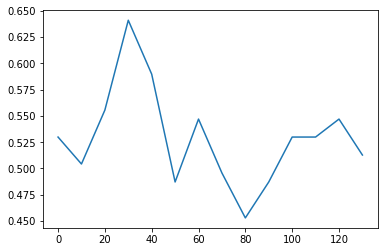

In [30]:
plt.plot(*zip(*cer_validation))

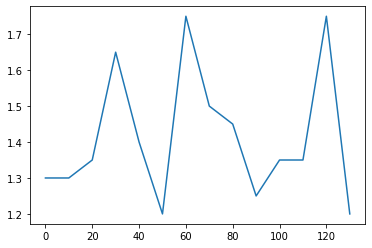

In [31]:
plt.plot(*zip(*wer_validation))

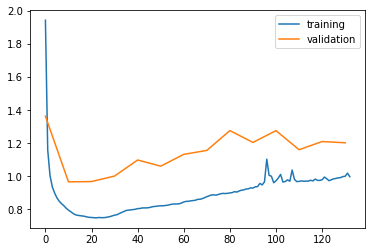

In [32]:
plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()

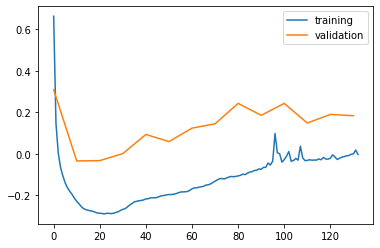

In [33]:
sum_loss_training = [(a, math.log(b)) for (a, b) in sum_loss_training]
sum_loss_validation = [(a, math.log(b)) for (a, b) in sum_loss_validation]

plt.plot(*zip(*sum_loss_training), label="training")
plt.plot(*zip(*sum_loss_validation), label="validation")

plt.legend()

In [36]:
from tabulate import tabulate

In [37]:
print(tabulate(cer_validation), flush=True)
print(tabulate(wer_validation), flush=True)
print(tabulate(sum_loss_training), flush=True)
print(tabulate(sum_loss_validation), flush=True)

---  --------
  0  0.529915
 10  0.504274
 20  0.555556
 30  0.641026
 40  0.589744
 50  0.487179
 60  0.547009
 70  0.495726
 80  0.452991
 90  0.487179
100  0.529915
110  0.529915
120  0.547009
130  0.512821
---  --------
---  ----
  0  1.3
 10  1.3
 20  1.35
 30  1.65
 40  1.4
 50  1.2
 60  1.75
 70  1.5
 80  1.45
 90  1.25
100  1.35
110  1.35
120  1.75
130  1.2
---  ----
---  ------------
  0   0.663576
  1   0.146753
  2   0.00308672
  3  -0.0664278
  4  -0.107111
  5  -0.140033
  6  -0.163559
  7  -0.181146
  8  -0.19587
  9  -0.213872
 10  -0.228834
 11  -0.240915
 12  -0.254368
 13  -0.264375
 14  -0.268908
 15  -0.271751
 16  -0.275038
 17  -0.276712
 18  -0.281743
 19  -0.285049
 20  -0.286042
 21  -0.287566
 22  -0.289605
 23  -0.286305
 24  -0.287168
 25  -0.287931
 26  -0.286299
 27  -0.282702
 28  -0.278996
 29  -0.272844
 30  -0.267467
 31  -0.264344
 32  -0.2556
 33  -0.246836
 34  -0.239543
 35  -0.23126
 36  -0.22895
 37  -0.225884
 38  -0.22478
 39  -0.222153
 40  -0

In [43]:
d = {
    'Epoch': [e[0] for e in cer_validation],
    'CER Validation': [e[1] for e in cer_validation],
    'WER Validation': [e[1] for e in wer_validation],
    'Loss Validation': [e[1] for e in sum_loss_validation],
    'Gradient': gradient_norm,
}

print(tabulate(d, headers="keys"), flush=True)

d = {
    'Epoch': [e[0] for e in sum_loss_training],
    'Loss Training': [e[1] for e in sum_loss_training],
}

print(tabulate(d, headers="keys"), flush=True)

  Epoch    CER Validation    WER Validation    Loss Validation    Gradient
-------  ----------------  ----------------  -----------------  ----------
      0          0.529915              1.3          0.309332       6.46069
     10          0.504274              1.3         -0.0343408     41.6196
     20          0.555556              1.35        -0.0325467     38.1819
     30          0.641026              1.65         0.00134385    75.1292
     40          0.589744              1.4          0.0936486    184.185
     50          0.487179              1.2          0.0591062     81.9397
     60          0.547009              1.75         0.124116     203.869
     70          0.495726              1.5          0.145018     167.306
     80          0.452991              1.45         0.243382     314.097
     90          0.487179              1.25         0.185909     319.819
    100          0.529915              1.35         0.243235     177.22
    110          0.529915              1.3

In [ ]:
# print(torch.cuda.memory_summary(), flush=True)

In [ ]:
# Print performance
pr.disable()
s = StringIO()
ps = (
    pstats
    .Stats(pr, stream=s)
    .strip_dirs()
    .sort_stats("cumtime")
    .print_stats(20)
)
print(s.getvalue(), flush=True)
print("stop time: {}".format(str(datetime.now())), flush=True)